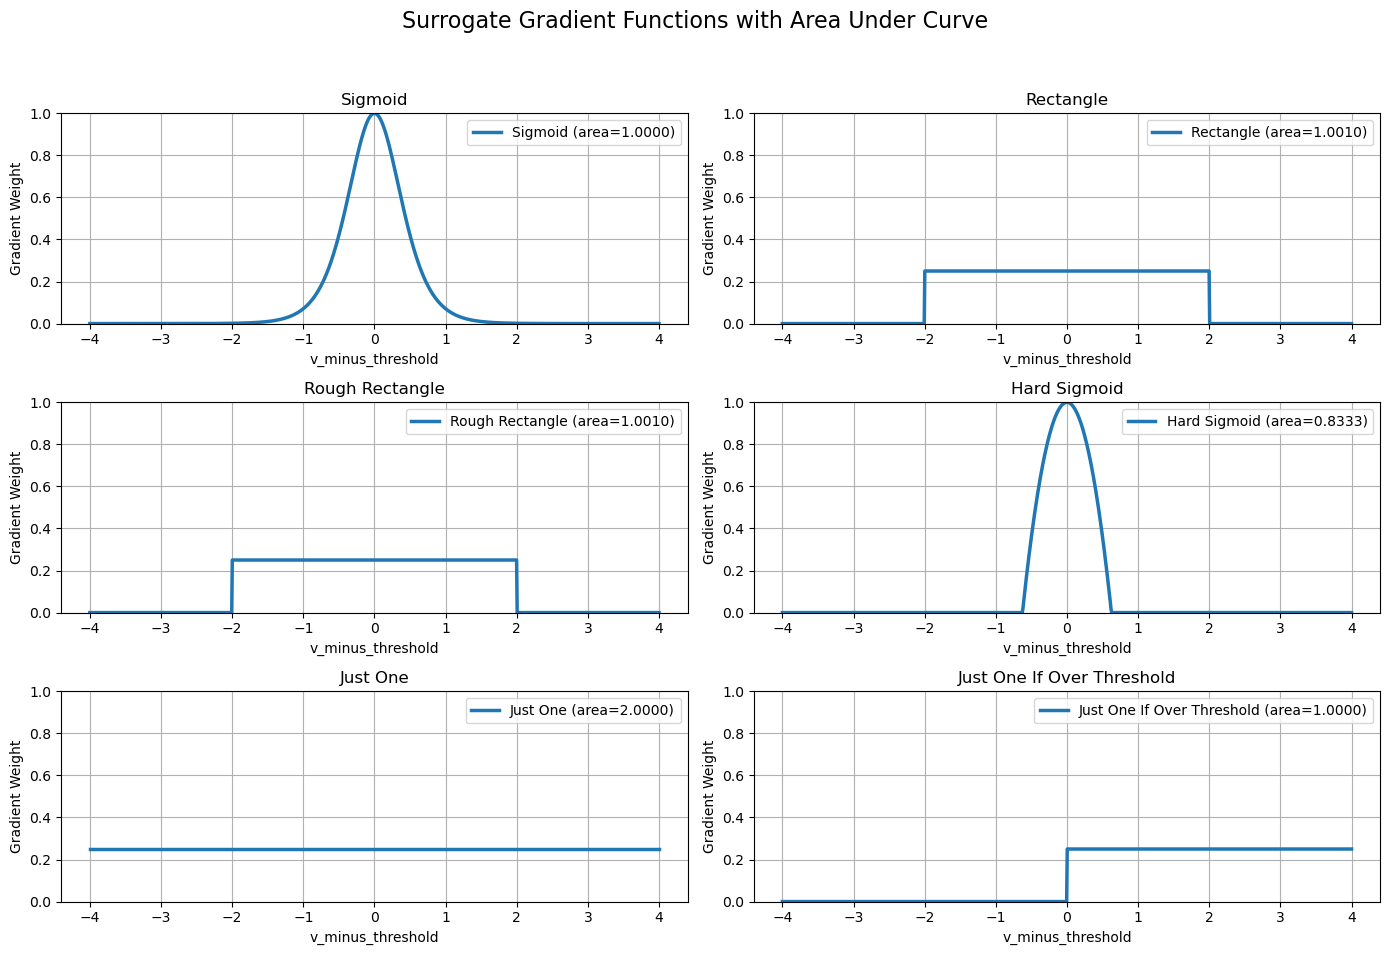

📐 Area under each surrogate gradient curve:
- Sigmoid: 1.000000
- Rectangle: 1.001001
- Rough Rectangle: 1.001001
- Hard Sigmoid: 0.833350
- Just One: 2.000000
- Just One If Over Threshold: 1.000000


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson

# surrogate 종류
surrogate_names = {
    1: "Sigmoid",
    2: "Rectangle",
    3: "Rough Rectangle",
    4: "Hard Sigmoid",
    5: "Just One",
    6: "Just One If Over Threshold"
}

# 설정
v = torch.linspace(-4, 4, steps=1000)
v2 = torch.linspace(-4, 4, steps=1000)
v_np = v2.numpy()
grad_output = torch.ones_like(v)
sg_width = 4.0

# subplot 설정
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

areas = {}  # 면적 저장용

for surrogate in range(1, 7):
    v_clone = v.clone()
    go = grad_output.clone()

    if surrogate == 1:
        alpha = sg_width
        sig = torch.sigmoid(alpha * v_clone)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 2:
        grad = (v_clone.abs() <= sg_width / 2).float() / sg_width
    elif surrogate == 3:
        go[v_clone.abs() > sg_width / 2] = 0
        grad = go / sg_width
    elif surrogate == 4:
        alpha = sg_width
        sig = torch.clamp(alpha * v_clone * 0.2 + 0.5, min=0, max=1)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 5:
        grad = torch.ones_like(v_clone) / sg_width
    elif surrogate == 6:
        go[v_clone < 0.0] = 0
        grad = go / sg_width

    grad_np = grad.numpy()
    area = simpson(grad_np, v_np)
    # area = np.trapz(grad_np, v_np)
    areas[surrogate_names[surrogate]] = area

    axs[surrogate - 1].plot(v_np, grad_np, label=f"{surrogate_names[surrogate]} (area={area:.4f})", linewidth=2.5)
    axs[surrogate - 1].set_title(surrogate_names[surrogate])
    axs[surrogate - 1].set_xlabel("v_minus_threshold")
    axs[surrogate - 1].set_ylabel("Gradient Weight")
    axs[surrogate - 1].grid(True)
    axs[surrogate - 1].set_ylim(0, 1)  # y축 고정
    axs[surrogate - 1].legend()

plt.suptitle("Surrogate Gradient Functions with Area Under Curve", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 면적 출력
print("📐 Area under each surrogate gradient curve:")
for name, area in areas.items():
    print(f"- {name}: {area:.6f}")
